In [1]:
!pip install pot
!pip install torch
!pip install geomloss
!pip install wget


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

from geomloss import SamplesLoss

import ot

import os
import pickle as pkl
import copy

from sklearn.preprocessing import scale
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from utils import *
from SoftImpute import softimpute, cv_softimpute
from DataSetLoader import dataset_loader, ground_truth
from SinkhornImputation import SinkhornImputation
from Sinkhorn_CMI import SinkhornImputation_CMI
from RR_imputer import RRimputer
import matplotlib.pyplot as plt

import argparse
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

torch.set_default_tensor_type('torch.DoubleTensor')

c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [3]:
Xy = {}
with open(r'C:\Users\zhossai3\Desktop\My code\OT+Fairness\Data\German Credit\German_Credit_Ground_Truth.csv', 'rb') as f:
        df = pd.read_csv(f, delimiter=',', header = 0)
        Xy['data'] = df.values[:, :-1].astype('float')
        Xy['target'] =  df.values[:, -1]

In [4]:
ground_truth_numpy = scale(Xy['data'])
print(type(ground_truth_numpy))

<class 'numpy.ndarray'>


In [5]:
print(np.max(ground_truth_numpy))
print(np.min(ground_truth_numpy))
print(np.mean(ground_truth_numpy))
print(np.median(ground_truth_numpy))
print(np.std(ground_truth_numpy))

5.370788962701069
-2.9144920787984168
5.2501213253385183e-17
-0.1337104553845832
1.0


In [6]:
print(ground_truth_numpy)

[[ 2.76645648  0.67028006  0.14694918 ... -0.74513141 -1.23647786
   1.07326286]
 [-1.19140394 -1.49191369  0.14694918 ...  0.94981679  2.24819436
   1.07326286]
 [ 1.18331231  0.67028006 -1.38377145 ... -0.41656241 -0.73866754
   0.06170503]
 ...
 [ 0.21583532  0.67028006  0.14694918 ... -0.87450324 -0.73866754
   1.07326286]
 [-1.10345149  0.67028006  0.14694918 ... -0.50552769  1.9992892
   1.07326286]
 [-0.75164167  0.67028006  0.14694918 ...  0.46245715  1.9992892
  -0.9498528 ]]


In [7]:
print(ground_truth_numpy.shape)
ground_truth = torch.from_numpy(ground_truth_numpy)
print(ground_truth.isnan().sum())

(1000, 9)
tensor(0)


In [8]:
#30% MCAR
np.random.seed(42)

p_macr30 = 0.301


mask_mcar30 = np.random.rand(*ground_truth.shape) < p_macr30  # True for missing values, false for others
data_mcar30 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar30[mask_mcar30] = np.nan

# Convert to a torch tensor
data_mcar30 = torch.from_numpy(data_mcar30)

# Calculate the percentage of missing values
missing_values_mcar30 = torch.isnan(data_mcar30)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar30 = torch.sum(missing_values_mcar30).item() / data_mcar30.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar30:.2f}%")

Percentage of missing values: 30.70%


In [9]:
data_mcar30_numpy = data_mcar30.detach().cpu().numpy()

In [10]:
#sinkhorn
n_mcar30, d_mcar30 = data_mcar30.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
#epsilon_mcar30 = pick_epsilon(data_mcar30)
epsilon_mcar30 = 0.3
print(epsilon_mcar30)


0.3


In [11]:
sk_imputer_mcar30 = SinkhornImputation_CMI(eps=epsilon_mcar30, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar30, sk_maes30mcar, sk_rmses30mcar,sk_loss_mcar30 = sk_imputer_mcar30.fit_transform(data_mcar30, verbose=True, report_interval=50, X_true=ground_truth)
#using numpy version of data
sk_imp_mcar30_numpy = sk_imp_mcar30.detach().cpu().numpy()

sk_mae_mcar30 = MAE(sk_imp_mcar30_numpy,ground_truth_numpy ,mask_mcar30)
sk_rmse_mcar30 = RMSE(sk_imp_mcar30_numpy, ground_truth_numpy,mask_mcar30)
print(sk_mae_mcar30,sk_rmse_mcar30)

INFO:root:Iteration 0:	 Loss: 1.5283	 Validation MAE: 0.7792	RMSE: 0.9954
INFO:root:Iteration 50:	 Loss: 1.2921	 Validation MAE: 0.7375	RMSE: 0.9924
INFO:root:Iteration 100:	 Loss: 1.2912	 Validation MAE: 0.7246	RMSE: 0.9906
INFO:root:Iteration 150:	 Loss: 1.3858	 Validation MAE: 0.7180	RMSE: 0.9919
INFO:root:Iteration 200:	 Loss: 1.4456	 Validation MAE: 0.7157	RMSE: 0.9944
INFO:root:Iteration 250:	 Loss: 1.3613	 Validation MAE: 0.7153	RMSE: 0.9976
INFO:root:Iteration 300:	 Loss: 1.2979	 Validation MAE: 0.7146	RMSE: 0.9989
INFO:root:Iteration 350:	 Loss: 1.1070	 Validation MAE: 0.7145	RMSE: 1.0001
INFO:root:Iteration 400:	 Loss: 1.2319	 Validation MAE: 0.7122	RMSE: 0.9982
INFO:root:Iteration 450:	 Loss: 1.2860	 Validation MAE: 0.7120	RMSE: 0.9991
INFO:root:Iteration 500:	 Loss: 1.4366	 Validation MAE: 0.7131	RMSE: 1.0021
INFO:root:Iteration 550:	 Loss: 1.4740	 Validation MAE: 0.7142	RMSE: 1.0043
INFO:root:Iteration 600:	 Loss: 1.3197	 Validation MAE: 0.7144	RMSE: 1.0038
INFO:root:Itera

0.7343692743730498 1.0341429834711229


In [12]:
print(sk_loss_mcar30)
#sk_loss_mcar30.clear

[1.5283027757242007, 1.2921419004891241, 1.2912446904247352, 1.3857966138260795, 1.4456416823389617, 1.3612733354757172, 1.2978658032873536, 1.1070259324069667, 1.2319283968588919, 1.286019468002195, 1.436562409487293, 1.4740226622341783, 1.3196975779380533, 1.3385332976930915, 1.3676369627506837, 1.273076201163857, 1.3113468373367392, 1.3689409497225244, 1.5379317752818618, 1.3565273706432728, 1.2317763881329156, 1.2802952755817687, 1.2621146757694173, 1.3181174539835467, 1.1950251474946818, 1.3525521968565224, 1.2308208930404776, 1.1782291043159114, 1.347429863624888, 1.5194185628834531, 1.2979581090391974, 0.9969469726518352, 1.3448427499750215, 1.375137521684819, 1.2391973086207897, 1.2167036104880968, 1.385316670577102, 1.0737607431411196, 1.386934568217391, 1.2328935473347014]


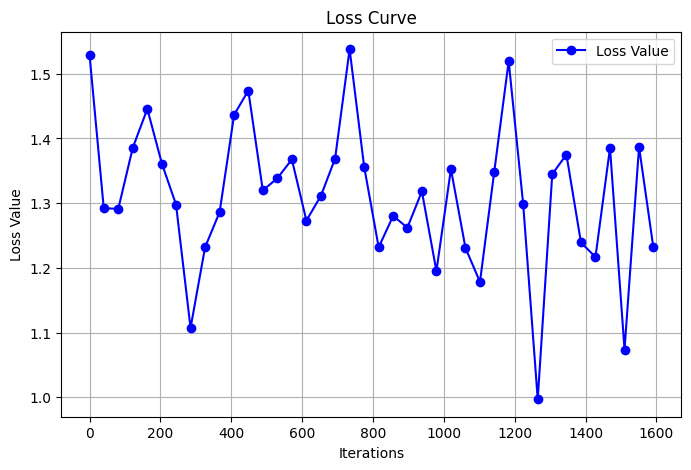

In [13]:
# Convert the list of losses to a NumPy array

iterations = np.linspace(0, 2000, 50).astype(int)



loss_values = sk_loss_mcar30


# Assuming cmi_penalty_history is also a list, convert it to a NumPy array
#cmi_penalty_history_numpy = np.array(cmi_penalty_history)

# Total loss calculation
#total_loss = sk_loss_mcar30_numpy + cmi_penalty_history_numpy
if len(loss_values) > len(iterations):
    loss_values = loss_values[:len(iterations)]
elif len(loss_values) < len(iterations):
    iterations = iterations[:len(loss_values)]



# Plotting
plt.figure(figsize=(8, 5))
plt.plot(iterations, loss_values, color='b', linestyle='-', marker='o', label="Loss Value")
plt.xlabel("Iterations")
plt.ylabel("Loss Value")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()



In [15]:
sk_imp_mcar30

tensor([[ 2.7665,  0.6703,  0.1469,  ..., -0.4533, -1.2365,  1.0733],
        [-1.1914,  0.3817,  0.1469,  ...,  1.0415,  2.2482,  1.0733],
        [ 1.1833,  0.6621, -1.3838,  ..., -0.4166, -0.7387,  0.4549],
        ...,
        [-0.1681,  0.6703,  0.1469,  ..., -0.8745, -0.7387,  1.0733],
        [-1.1035,  0.6703,  0.1566,  ..., -0.5055,  1.9993, -0.9750],
        [-0.2472,  0.6703,  0.1469,  ...,  0.4625,  0.1119, -0.9499]],
       grad_fn=<IndexPutBackward0>)